# PyVBMC Example 5: Prior distributions

In this notebook, we discuss some considerations for using a prior distribution with PyVBMC, and demonstrate some convenient built-in priors.

This notebook is Part 5 of a series of notebooks in which we present various example usages for VBMC with the PyVBMC package. The code used in this example is available as a script [here](https://github.com/acerbilab/pyvbmc/blob/main/examples/scripts/pyvbmc_example_5_full_code.py).

## 0. Preliminaries

In Bayesian inference – and in PyVBMC – you *need* a [prior over parameters](https://en.wikipedia.org/wiki/Prior_probability), $p(\theta)$. The prior should be a proper probability density function (pdf), i.e. a normalized distribution. A common choice is an independent or factorized prior:

$$ p(\theta) = \prod_{i} p_{i}(\theta_{i}) \iff \log \big( p(\theta) \big) = \sum_{i} \log \big( p_{i}(\theta_{i}) \big)\,, $$

where each prior $p_{i}(\theta_{i})$ is chosen separately for each parameter $\theta_{i}$. Note that an independent prior does not mean that the posterior is independent!

## 1. Specifying a prior with PyVBMC

By default, as in the previous notebooks, PyVBMC assumes that the first argument to `VBMC` is a function which returns the log-joint (i.e., the sum of log-likelihood and log-prior). However, you may instead pass a function which returns the log-likelihood as a first argument, and supply the prior separately. Using the keyword `log_prior`, you may pass a function (of a single argument) which returns the log-density of the prior given a point:

```python
vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, log_prior=log_prior_function)
```

Alternatively, using the keyword `prior`, you may pass one of the following:

1. a (multivariate) PyVBMC prior imported from `pyvbmc.priors`,
2. an appropriate (multivariate) continuous `scipy.stats` distribution, or
3. a list of univariate (i.e., one-dimensional) PyVBMC priors and/or continuous `scipy.stats` distributions, which are treated as independent priors for each parameter $\theta_{i}$.

```python
vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, prior=UniformBox(0, 1, D=2))
vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, prior=scipy.stats.multivariate_normal(mu, cov))
vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, prior=[UniformBox(0, 1), scipy.stats.norm()])
```

Below we detail the built-in PyVBMC priors (1) for various use-cases. See the [relevant documentation](https://acerbilab.github.io/pyvbmc/api/classes/priors.html) for details on other types of priors, and the [examples below](#4.-Using-a-prior-with-PyVBMC) for some usage cases.

In [1]:
import numpy as np
import scipy.stats as scs
from pyvbmc import VBMC
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [20, 6]

## 2. Bounded parameters

PyVBMC implements several priors for bounded parameters. All the priors listed below apply to the multivariate case, with the assumption of independent/factorized priors mentioned above.

#### Uniform-box prior (`UniformBox`)

For bounded parameters, the first simple choice is a non-informative uniformly flat prior between the hard bounds. This is implemented by the `UniformBox` multivariate prior. Below, we plot the pdf of the prior for a one-dimensional problem (the pdf to the left and the log-pdf to the right).

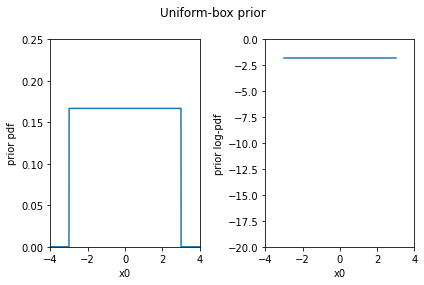

In [3]:
lb = -3
ub = 3
plb = -2
pub = 2
x = np.linspace(lb - 1, ub + 1, 1000)

prior = UniformBox(lb, ub)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(x, prior.pdf(x))
ax1.set_xlim(-4, 4)
ax1.set_ylim(0, 0.25)
ax1.set_xlabel("x0")
ax1.set_ylabel("prior pdf")
ax2.plot(x, prior.log_pdf(x))
ax2.set_ylim(-20, 0)
ax2.set_xlabel("x0")
ax2.set_ylabel("prior log-pdf")
plt.suptitle("Uniform-box prior")
fig.tight_layout()
# (Note that the log-pdf is not plotted where it takes values of -infinity.)

#### Trapezoidal prior (`Trapezoidal`)

Alternatively, for each parameter we can define the prior to be flat within a range, where a reasonable choice is the "plausible" range, and then falls to zero towards the hard bounds. This is a trapezoidal or "tent" prior, implemented by the `Trapezoidal` prior shown below.

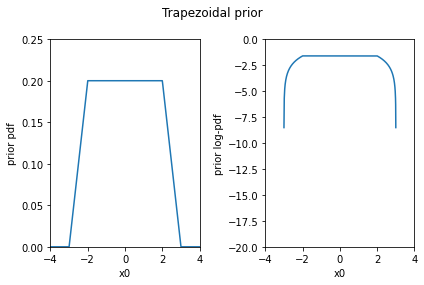

In [4]:
prior = Trapezoidal(lb, plb, pub, ub)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(x, prior.pdf(x))
ax1.set_xlim(-4, 4)
ax1.set_ylim(0, 0.25)
ax1.set_xlabel("x0")
ax1.set_ylabel("prior pdf")
ax2.plot(x, prior.log_pdf(x))
ax2.set_ylim(-20, 0)
ax2.set_xlabel("x0")
ax2.set_ylabel("prior log-pdf")
plt.suptitle("Trapezoidal prior")
fig.tight_layout()

#### Spline-smoothed trapezoidal prior (`SplineTrapezoidal`)

Finally, we can use a *smoothed* trapezoidal prior with soft transitions at the edges obtained using cubic splines. This prior is better behaved numerically as it is continuous with continuous derivatives (i.e., no sharp edges), so we recommend it over the simple trapezoidal prior. The spline-smoothed trapezoidal prior is implemented by the `SplineTrapezoidal` class.

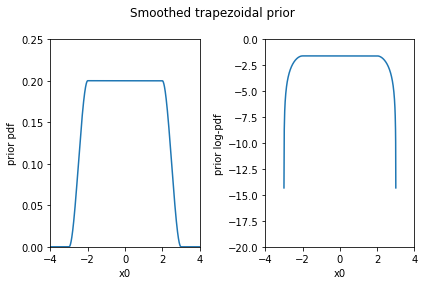

In [5]:
prior = SplineTrapezoidal(lb, plb, pub, ub)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(x, prior.pdf(x))
ax1.set_xlim(-4, 4)
ax1.set_ylim(0, 0.25)
ax1.set_xlabel("x0")
ax1.set_ylabel("prior pdf")
ax2.plot(x, prior.log_pdf(x))
ax2.set_ylim(-20, 0)
ax2.set_xlabel("x0")
ax2.set_ylabel("prior log-pdf")
plt.suptitle("Smoothed trapezoidal prior")
fig.tight_layout()

## 3. Unbounded parameters

If your variables are *unbounded*, remember that PyVBMC supports `scipy.stats` univariate and multivariate distributions, so you  could use standard priors such as a multivariate normal distribution or a multivariate Student's t distribution with 3-7 degrees of freedom. 
See for example [this page on the Stan wiki](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) for a broader discussion on prior choice.

#### Smooth-box prior (`SmoothBox`)

As an alternative to these common choices, we also provide a smooth-box distribution which is uniform within an interval (typically, the plausible range) and then falls with Gaussian tails with scale(s) `sigma` outside the interval. The smoothbox prior is implemented by the `SmoothBox` class.

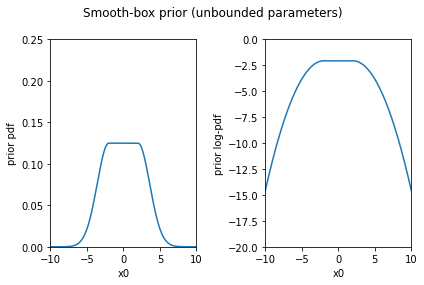

In [6]:
lb = -np.inf
ub = np.inf
plb = -2
pub = 2
# We recommend setting sigma as a fraction of the plausible range.
# For example sigma set to 4/10 of the plausible range assigns ~50%
# (marginal) probability to the plateau of the distribution.
# Also similar fractions (e.g., half of the range) would be reasonable.
# Do not set sigma too small with respect to the plausible range, as it
# might cause issues.
p_range = pub - plb
sigma = 0.4 * p_range

prior = SmoothBox(plb, pub, sigma)

x = np.linspace(plb - 2 * p_range, pub + 2 * p_range, 1000)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(x, prior.pdf(x))
ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(0, 0.25)
ax1.set_xlabel("x0")
ax1.set_ylabel("prior pdf")
ax2.plot(x, prior.log_pdf(x))
ax2.set_ylim(-20, 0)
ax2.set_xlabel("x0")
ax2.set_ylabel("prior log-pdf")
plt.suptitle("Smooth-box prior (unbounded parameters)")
fig.tight_layout()

## 4. Using a prior with PyVBMC


To conclude, we run inference on a couple of problems using some of the priors introduced in this notebook.

#### Bounded example

In this example, we use the spline-smoothed trapezoidal prior (`SplineTrapezoidal`) introduced in this notebook. The code below shows several equivalent ways in which the prior can be set in PyVBMC (see the comments in the code below for details).

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -1.41         1.15    310361.34        2        inf     start warm-up
     1         15          -3.31         0.26        13.00        2        inf     
     2         20          -3.05         0.02         0.36        2       9.32     
     3         25          -3.03         0.01         0.20        2       4.89     
     4         30          -3.02         0.00         0.04        2      0.947     end warm-up
     5         35          -3.06         0.00         0.01        2      0.332     
     6         40          -3.02         0.00         0.00        2      0.193     
     7         45          -2.66         0.01         0.16        5       4.93     
     8         50          -2.61         0.00         0.02        6      0.588     
     9         50          -2.53         0.05    

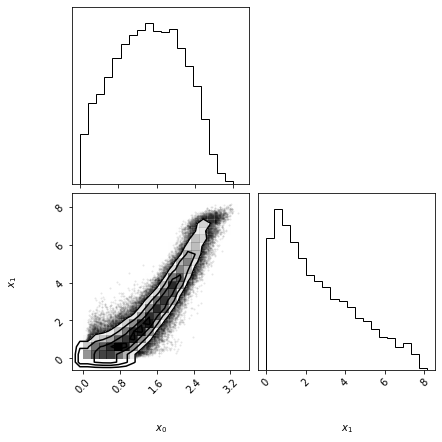

In [7]:
D = 2  # Still in 2-D
lb = np.zeros((1, D))
ub = 10 * np.ones((1, D))
plb = 0.1 * np.ones((1, D))
pub = 3 * np.ones((1, D))

# Define the prior and the log-likelihood
prior = SplineTrapezoidal(lb, plb, pub, ub)


def log_likelihood(theta):
    """D-dimensional Rosenbrock's banana function."""
    theta = np.atleast_2d(theta)

    x, y = theta[:, :-1], theta[:, 1:]
    return -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)


x0 = np.ones((1, D))
np.random.seed(42)
vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, prior=prior)
# vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, log_prior=prior.log_pdf)  # equivalently
# vbmc = VBMC(lambda x: log_likelihood(x) + prior.log_pdf(x), x0, lb, ub, plb, pub)  # equivalently
vp, results = vbmc.optimize()
vp.plot();

#### Unbounded example

We run now another example with an unbounded prior. In this case, we apply a multivariate normal prior with zero mean and diagonal covariance, with variance $\sigma^2 = 9$ in each dimension (we chose $\sigma$ equal to half the plausible range). 
Note that this is equivalent to setting a normal distribution separately for each variable. The code below shows a couple of equivalent ways in which the prior could be initialized in PyVBMC using `scipy.stats` distributions.

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -3.17         0.83      5094.29        2        inf     start warm-up
     1         15          -2.90         0.08         0.24        2        inf     
     2         20          -2.81         0.00         0.09        2       2.52     
     3         25          -2.82         0.00         0.01        2       0.28     
     4         30          -2.80         0.00         0.01        2      0.224     end warm-up
     5         35          -2.78         0.00         0.00        2      0.136     
     6         40          -2.78         0.00         0.00        2     0.0739     
     7         45          -2.53         0.00         0.23        5       6.26     
     8         50          -2.43         0.00         0.04        6       1.28     
     9         55          -2.41         0.00    

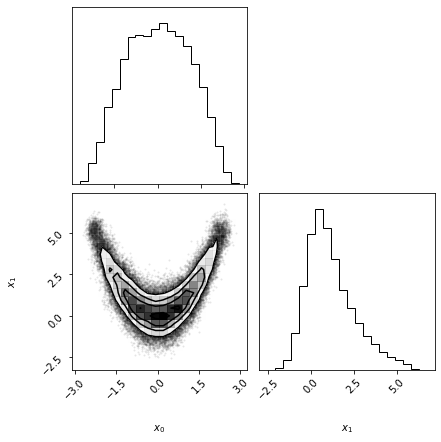

In [8]:
D = 2  # Still in 2-D
lb = np.full((1, D), -np.inf)
ub = np.full((1, D), np.inf)
plb = -3*np.ones((1, D))
pub = 3*np.ones((1, D))

# Define the prior as a multivariate normal (scipy.stats distribution)
scale = 0.5*(pub - plb).flatten()
prior = scs.multivariate_normal(mean=np.zeros(D),cov=scale**2)
#prior = [scs.norm(scale=scale[0]),scs.norm(scale=scale[1])] # equivalently

x0 = np.zeros((1, D))
np.random.seed(42)
vbmc = VBMC(log_likelihood, x0, lb, ub, plb, pub, prior=prior)
vp, results = vbmc.optimize()
vp.plot();

## Acknowledgments

Work on the PyVBMC package was funded by the [Finnish Center for Artificial Intelligence FCAI](https://fcai.fi/).